# Scipy vs Pandas interpolation documentation missmatching

We can find information in [Pandas documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.interpolate.html) that, Pandas interpolation module on both - Series and on DataFrames, pases input data to Scipy `scipy.interpolate.interp1d` method. We can read about method paramter:

`'nearest’, ‘zero’, ‘slinear’, ‘quadratic’, ‘cubic’, ‘spline’, ‘barycentric’, ‘polynomial’: Passed to scipy.interpolate.interp1d. These methods use the numerical values of the index. Both ‘polynomial’ and ‘spline’ require that you also specify an order (int), e.g. df.interpolate(method='polynomial', order=5).`

Thus, user might think that Pandas, uses methods of `scipy.interpolate.interp1d` to all interpolation methods. But as it shown in below code, this is true for `slinear` and not for `spline`. This is also visible in the `pandas.core.missing._interpolate_scipy_wrapper` function definition, where we can find that `spline`in fact uses `interpolate.UnivariateSpline` to predict gaps in the data. 

This might confuse end user because in [scipy.interpolate.interp1d](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html#scipy.interpolate.interp1d) documentation might be found that `slinear` method refer to a spline interpolation of first orger. At the same time, end user can read in [pandas.Series.interpolate](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.interpolate.html) that `spline` require that you also specify an order (int), e.g 1, as in this work. 

Summarizing: 
1. Pandas `slinear` refers to Scipy `slinear`, but Scipy `slinear` refers to first order `spline` method with order 1, which is defined separatley in Pandas.
2. `pandas.core.missing._interpolate_scipy_wrapper` points that Pandas does not use for interpolation `scipy.interpolate.interp1d` for `spline` as for `slinear`. Pandas uses `interpolate.UnivariateSpline` for `spline` interpolation, what is not pointed in the [pandas.Series.interpolate](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.interpolate.html) documentation.
3. Scipy slinear and linear give the same results.
4. Pandas slinear gives the same results as Scipy slinear
5. Pandas slinear does not gives the same results as Pandas first order spline, to which Scipy slinear refers to.





In [9]:
"""Dependencies."""
import scipy
from scipy import interpolate
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import functools
from typing import Tuple

print("Scipy version: ", scipy.__version__) #  Tested on 1.8.0, but 1.9.3 have the same description.
print("Pandas version", pd.__version__) #  Tested on 1.4.2, but 1.5.1 have the same description.

Scipy version:  1.8.0
Pandas version 1.4.2


In [2]:
"""Propose data."""
x = [i for i in range(-10, 11, 1)]
y_all = [0, 0, 0, 0, 0, 0, 0, 0, 2, 5, 10, 5, 2, 0, 0, 0, 0, 0, 0, 0, 0,]
y_gap_1 = [0, np.nan, 0, np.nan, 0, np.nan, 0, np.nan, 2, np.nan, 10, np.nan, 2, np.nan, 0, np.nan, 0, np.nan, 0, np.nan, 0,]
y_gap_2 = [0, np.nan, 0, 0, np.nan, 0, 0, np.nan, np.nan, 5, 10, np.nan, 2, 0, np.nan, 0, 0, 0, np.nan, 0, 0,]

In [3]:
"""Functions for both libraries."""
def plot(original: pd.Series,
         gaps_1_method_1: pd.Series, 
         gaps_1_method_2: pd.Series, 
         gaps_2_method_1: pd.Series, 
         gaps_2_method_2: pd.Series) -> Tuple[plt.Figure, plt.Axes, plt.Axes]:
    
    fig, (gaps_1, gaps_2) = plt.subplots(nrows=2, ncols=1, sharex=True)
    
    original.plot(ax=gaps_1)
    gaps_1_method_1.plot(ax=gaps_1)   
    gaps_1_method_2.plot(ax=gaps_1)
    gaps_1.legend()
    gaps_1.grid()
    gaps_1.set_ylabel("Gaps case 1 - y[-]")

    original.plot(ax=gaps_2)
    gaps_2_method_1.plot(ax=gaps_2)
    gaps_2_method_2.plot(ax=gaps_2)
    gaps_2.legend()
    gaps_2.grid()
    gaps_2.set_ylabel("Gaps case 2 - y[-]")
    gaps_2.set_xlabel("x[-]")

    fig.tight_layout()
    
    return fig, gaps_1, gaps_2

In [4]:
"""Preprocess data for both libraries."""
original = pd.Series(data=y_all, index=x, name="Original")
gaps_1 = pd.Series(data=y_gap_1, index=x, name="Original with gaps 1")
gaps_2 = pd.Series(data=y_gap_2, index=x, name="Original with gaps 2")

In [5]:
"""Check Scipy interpolation behaviur."""
x_gaps_1 = gaps_1.dropna().index.to_numpy()
y_gaps_1 = gaps_1.dropna().to_numpy() 

x_gaps_2 = gaps_2.dropna().index.to_numpy()
y_gaps_2 = gaps_2.dropna().to_numpy() 

f_gaps_1_linear = interpolate.interp1d(x_gaps_1, y_gaps_1, kind="linear")
f_gaps_2_linear = interpolate.interp1d(x_gaps_2, y_gaps_2, kind="linear")
f_gaps_1_slinear = interpolate.interp1d(x_gaps_1, y_gaps_1, kind="slinear")
f_gaps_2_slinear = interpolate.interp1d(x_gaps_2, y_gaps_2, kind="slinear")

gaps_1_linear_scipy = f_gaps_1_linear(x)
gaps_2_linear_scipy = f_gaps_2_linear(x)
gaps_1_slinear_scipy = f_gaps_1_slinear(x)
gaps_2_slinear_scipy = f_gaps_2_slinear(x)

gaps_1_linear_scipy = pd.Series(data=gaps_1_linear_scipy, index=x)
gaps_2_linear_scipy = pd.Series(data=gaps_2_linear_scipy, index=x)
gaps_1_slinear_scipy = pd.Series(data=gaps_1_slinear_scipy, index=x)
gaps_2_slinear_scipy = pd.Series(data=gaps_2_slinear_scipy, index=x)

gaps_1_linear_scipy.name = "scipy-linear"
gaps_2_linear_scipy.name = "scipy-linear"
gaps_1_slinear_scipy.name = "scipy-slinear"
gaps_2_slinear_scipy.name = "scipy-slinear"

In [6]:
"""Check Pandas behaviour, which uses Scipy interpolation module."""
gaps_1_spline_padas = gaps_1.interpolate(method="spline", order=1)
gaps_1_spline_padas.name = "pandas-spline, order 1"
gaps_2_spline_padas = gaps_2.interpolate(method="spline", order=1)
gaps_2_spline_padas.name = "pandas-spline, order 1"

gaps_1_slinear_padas = gaps_1.interpolate(method="slinear")
gaps_1_slinear_padas.name = "pandas-slinear"
gaps_2_slinear_padas = gaps_2.interpolate(method="slinear")
gaps_2_slinear_padas.name = "pandas-slinear"

,Original,Gaps,scipy-slinear,pandas-slinear,scipy-linear,"pandas-spline, order 1"
-10,0,0.0,0.0,0.0,0.0,0.000000
-9,0,NaN,0.0,0.0,0.0,-0.001371
-8,0,0.0,0.0,0.0,0.0,0.000000
-7,0,NaN,0.0,0.0,0.0,-0.155107
-6,0,0.0,0.0,0.0,0.0,0.000000
-5,0,NaN,0.0,0.0,0.0,-0.308843
-4,0,0.0,0.0,0.0,0.0,0.000000
-3,0,NaN,1.0,1.0,1.0,1.665101
-2,2,2.0,2.0,2.0,2.0,2.000000
-1,5,NaN,6.0,6.0,6.0,5.766726


,Original,Gaps,scipy-slinear,pandas-slinear,scipy-linear,"pandas-spline, order 1"
-10,0,0.0,0.000000,0.000000,0.000000,0.000000
-9,0,NaN,0.000000,0.000000,0.000000,-0.072812
-8,0,0.0,0.000000,0.000000,0.000000,0.000000
-7,0,0.0,0.000000,0.000000,0.000000,0.000000
-6,0,NaN,0.000000,0.000000,0.000000,0.100361
-5,0,0.0,0.000000,0.000000,0.000000,0.000000
-4,0,0.0,0.000000,0.000000,0.000000,0.000000
-3,0,NaN,1.666667,1.666667,1.666667,2.235646
-2,2,NaN,3.333333,3.333333,3.333333,3.823507
-1,5,5.0,5.000000,5.000000,5.000000,5.000000


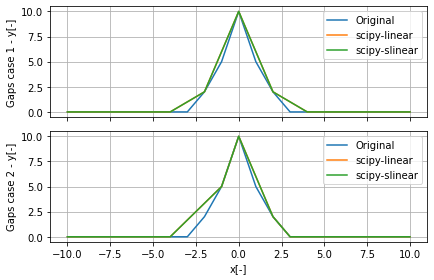

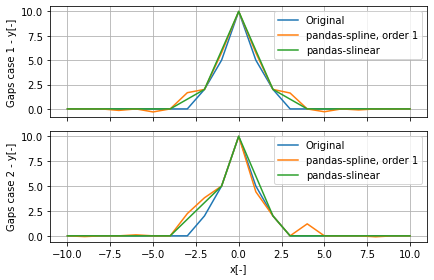

In [7]:
"""Data saving"""
fig_scipy, scipy_gaps_1_ax, scipy_gaps_2_ax = plot(
    original=original,
    gaps_1_method_1=gaps_1_linear_scipy,
    gaps_1_method_2=gaps_1_slinear_scipy,
    gaps_2_method_1=gaps_2_linear_scipy,
    gaps_2_method_2=gaps_2_slinear_scipy)
fig_scipy.savefig("scipy_interpolation.png")

fig_pandas, pandas_gaps_1_ax, pandas_gaps_2_ax = plot(
    original=original,
    gaps_1_method_1=gaps_1_spline_padas,
    gaps_1_method_2=gaps_1_slinear_padas,
    gaps_2_method_1=gaps_2_spline_padas,
    gaps_2_method_2=gaps_2_slinear_padas)
fig_pandas.savefig("pandas_interpolation.png")

gaps_1_df = pd.concat([original,
                       pd.Series(data=y_gap_1, index=x, name="Gaps"),
                       gaps_1_slinear_scipy,
                       gaps_1_slinear_padas, 
                       gaps_1_linear_scipy, 
                       gaps_1_spline_padas], axis="columns")
gaps_1_df.to_csv("case_1_comparison.csv")
display(gaps_1_df)

gaps_2_df = pd.concat([original,
                       pd.Series(data=y_gap_2, index=x, name="Gaps"),
                       gaps_2_slinear_scipy,
                       gaps_2_slinear_padas, 
                       gaps_2_linear_scipy, 
                       gaps_2_spline_padas], axis="columns")
gaps_2_df.to_csv("case_2_comparison.csv")
display(gaps_2_df)